# PID Tuning optimization study

This project aims at studying the tuning process through optimization for various PIDs.

- Considered controller / PID
    - [x] Filtered PID
    - [ ] PID + anti-windup
    - [ ] PID + feed forward
    - [ ] PID + measure only derivative
    - [ ] PID + all
- Considered fitness function
    - [x] ITAE
    - [x] ITSE
    - [ ] ISE
    - [ ] IAE
    - [ ] MSE

In [1]:
import control as ct
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Markdown as md
s = ct.tf("s")

## Quadcopter single axis

```mermaid
flowchart LR
    position --> att_fb(("+")) --> att_ctrl --> rate_fb(("+")) --> rate_ctrl --> mot1 & mot2
    mot1 --> prop1 --> sum(("-"))
    mot2 --> prop2 --> sum --> rate --> attitude & rate_fb
    attitude --> att_fb
    att_ctrl["`Attitude
               controller`"]
    rate_ctrl["`Rate
                controller`"]
    mot1[Motor 1]
    mot2[Motor 2]
    prop1[Propeller]
    prop2[Propeller]
```
Hyptohesis:
- the quadcopter has a single axis, with two motors (1 and 2)
- the model is linearized around the hover state

The quadcopter body model is ($\theta$ as the angular position):
$$
\begin{bmatrix} \dot{\theta} \\ \ddot{\theta} \end{bmatrix} =
\begin{bmatrix} 0 & 1 \\ 0 & 0 \end{bmatrix}
\begin{bmatrix} \theta \\ \dot{\theta} \end{bmatrix} +
\begin{bmatrix} 0 & 0 \\ \frac{d}{J} & -\frac{d}{J} \end{bmatrix}
\begin{bmatrix} F_1 \\ F_2 \end{bmatrix}
$$

The force is generated by the propellers spinning at the motors speed:

$$
F = C_t.\Omega^2
$$

The motor model is:

$$
\begin{bmatrix} \dot{\Omega}\end{bmatrix} =
\begin{bmatrix} \frac{-1}{T_m} \end{bmatrix}
\begin{bmatrix} \Omega \end{bmatrix} +
\begin{bmatrix} \frac{C_r}{T_m} \end{bmatrix}
\begin{bmatrix} \sigma \end{bmatrix} +
\begin{bmatrix} \frac{\Omega_b}{T_m} \end{bmatrix}
$$

In practice the controller allocates symetric commands to motors (command = $\Delta_1 = -\Delta_2$)

In [2]:
d = (np.sqrt(2) / 2) * 0.5  #  FIXME
J = 0.0119
Wb = 33.44
Cr = 658.89
Tm = 0.0164
Ct = 1.64e-5
PWM_scale = 200_000
mass = 0.9
G = 9.8


body = ct.ss([[0, 1], [0, 0]], [[0, 0], [d/J, -d/J]],  # A and B
             [[1, 0], [0, 1]], [[0, 0], [0, 0]],       # C and D
             inputs=["F_1", "F_2"],
             states=["theta", "thdot"],
             outputs=["theta", "theta_dot"],
             name="body")

hover_throttle = (np.sqrt((G * mass / 4) / Ct) - Wb) / Cr
hover_motor = Cr * hover_throttle + Wb
print(f"Linearizing at hover (throtlle={hover_throttle:.2f}, motor speed={hover_motor:.1f}rad/s)")


def thrust_update(t, x, u, params):
    omega_b = np.array([Wb, Wb])
    sigma = u[1] + np.array([u[0], -u[0]]) / PWM_scale
    return (Cr * sigma + omega_b - x) / Tm


def thrust_output(t, x, u, params):
    # Multiply output by 2 because there are 2 motors on each side
    return 2 * Ct * (x**2)


# System dynamics
thrust = ct.nlsys(
    thrust_update, thrust_output, name='thrust',
    states=["omega_1", "omega_2"],
    inputs=["delta", "throttle"], outputs=["F_1", "F_2"])


thrust_ss = thrust.linearize([hover_motor, hover_motor], [0, hover_throttle], copy_names=True)
quadcopter = ct.interconnect([thrust_ss, body],
                             name="quadcopter",
                             inplist=["thrust$linearized.delta"],
                             inputs=["delta"],
                             ignore_inputs=["thrust$linearized.throttle"],
                             outlist=["body.theta", "body.theta_dot"],
                             outputs=["theta", "theta_dot"],
                             states=["omega_1", "omega_2", "theta", "theta_dot"])
print(ct.tf(quadcopter))

Linearizing at hover (throtlle=0.51, motor speed=366.7rad/s)
<TransferFunction>: quadcopter$converted
Inputs (1): ['delta']
Outputs (2): ['theta', 'theta_dot']


Input 1 to output 1:
           0.2871
----------------------------
s^3 + 60.98 s^2 + 4.28e-20 s

Input 1 to output 2:
          0.2871 s
-----------------------------
s^3 + 60.98 s^2 - 6.054e-20 s



Text(0, 0.5, 'Motor speed')

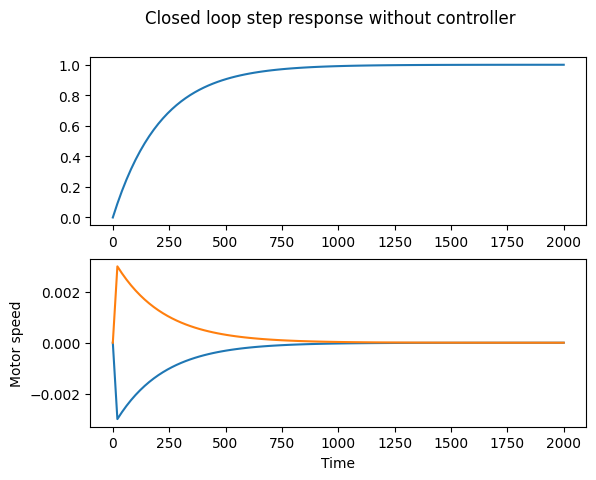

In [3]:
feedback = ct.ss([], [], [], [0, 1])
velocity = quadcopter.feedback(other=feedback)
step = ct.step_response(velocity, input=0, output=1, T=2000)
fig, axs = plt.subplots(2)
fig.suptitle('Closed loop step response without controller')
axs[0].plot(step.time, step.outputs)
axs[1].plot(step.time, step.states[-3])
axs[1].plot(step.time, step.states[-4])
axs[1].set_xlabel("Time")
axs[1].set_ylabel("Motor speed")

## PID controllers

### Regular PID

$$
G(s) = K_p.(1 + \frac{1}{T_i.s} + T_d.s) = Kp.\frac{T_i.T_d.s^2 + T_i.s + 1}{T_i.s}
$$
```mermaid
flowchart LR
    input --> feedback(("+")) --> P & I & D --> sum(("+")) --> G --> output
    G -- "-" --> feedback
```

### Derivative filter

In order to improve the derivative response to large changes in the reference, the derivative term is often combined with a low pass filter.
The derivative action is then:

$$
D = \frac{T_d.s}{\frac{T_d}{N}.s +1}
$$

with $N$ varying between 3 and 10. 

Note that `python control` does not support pure derivative term.
Therefore, this work uses filtered PID as the base PID.

In [4]:
def gen_pid(kp, ti, td, n=5):
    pid = kp * (1 + 1 / (ti * s) + (td * s) / (td / n * s + 1))
    return ct.ss(pid, name="pid")

### Anti windup

```mermaid
flowchart LR
    input --> error((+))
    error --> awsum((+))
    awsum --> I
    I --> sum
    error --> P & D --> sum((+))
    awsum ~~~ kaw --> awsum
    kaw ~~~ awsum
    kaw ~~~ awdiff --> kaw
    awdiff ~~~ kaw
    sum --> awdiff((+))
    sum --> saturation
    awdiff ~~~ saturation --> awdiff
    saturation ~~~ awdiff
    saturation --> output
    output --> error
```

In [5]:
def sat_update(t, x, u, params):
    return []


def sat_output(t, x, u, params):
    umax = params.get("umax", np.inf)
    return np.clip(u, -umax, umax)


sat = ct.nlsys(sat_update, sat_output,
               name="sat", inputs=1, outputs=1, states=0)


def gen_antiwindup_pid(kp, ti, td, umax=20000, kaw=1, n=10):
    P = ct.tf([kp], [1], name="p")
    I = ct.tf([kp], [ti, 0], name="i")
    D = ct.tf([kp * td, 0], [td/n, 1], name="d")
    pid_sum = ct.tf([1], [1], name="sum")
    return ct.interconnect([P, I, D, pid_sum, sat],
                           connections=[
                               ['i.u', ('sum', 'y', -kaw), ('sat', 'y', kaw)],
                               ['sum.u', 'p.y', 'i.y', 'd.y'],
                               ['sat.u', 'sum.y']],
                           inplist=[['p.u', 'i.u'], 'd.u'],
                           outlist=[['sat.y'], ['sum.y']],
                           inputs=["error", "measure"],
                           outputs=['y', 'y_int'],
                           name="pid",
                           params={"umax": umax})

## Fitness functions

Comparison between different fitness functions \[[1](https://iopscience.iop.org/article/10.1088/1757-899X/1096/1/012061/pdf)\]

### Integral time absolute error

$$
itae = \int |\varepsilon|*t\,dt
$$

In [6]:
def itae(time, output, reference=1):
    return np.sum(np.abs(reference - output) * time)

### Integral time squarred error

$$
itse = \int \varepsilon^2*t\,dt
$$

In [7]:
def itse(time, output, reference=1):
    return np.sum(np.square(reference - output) * time)

## PID Tuninng

Let's use `scipy` to tune the PID using the `differential_evolution` algorithm.

In [8]:
from scipy.optimize import differential_evolution

In [9]:
def target(x, *args):
    fitness = args[0]
    kp, ti, td = x
    pid = gen_pid(kp, ti, td)
    sys = ct.series(pid, quadcopter).feedback(feedback)
    step = ct.step_response(sys, T=0.5, output=1)
    return fitness(step.time, step.outputs[0])

boundaries = ([1e3, 5e3], [1e-1, 2e1], [1e-1, 3e1])

### ITAE tuning

In [10]:
itae_best = differential_evolution(target, boundaries, polish=True, args=(itae,))

ITAE result:
- kp=1799.31
- ti=1.10
- td=25.33
- score=0.40

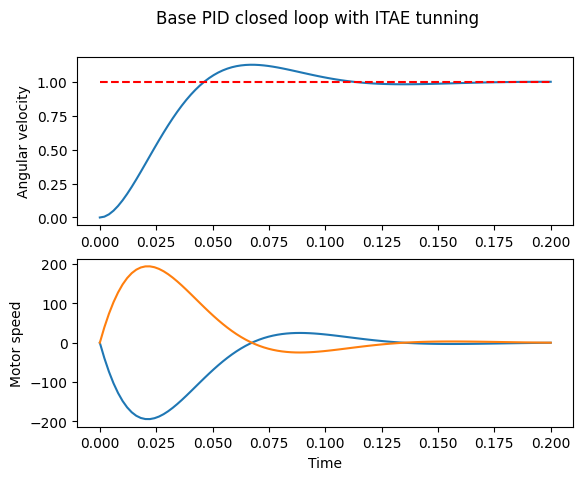

In [11]:
kp, ti, td = itae_best.x
itae_pid = gen_pid(kp, ti, td)
itae_loop = ct.series(itae_pid, quadcopter).feedback(feedback)
itae_step = ct.step_response(itae_loop, T=0.2, output=1)
itae_info = ct.step_info(ct.series(itae_loop, ct.ss([], [], [], [0, 1])), T=0.5, yfinal=1)
score = itae(itae_step.time, itae_step.outputs)
fig, axs = plt.subplots(2)
fig.suptitle('Base PID closed loop with ITAE tunning')
axs[0].plot(itae_step.time, itae_step.outputs[0][0])
axs[0].plot(itae_step.time, itae_step.u[0][0], '--r')
axs[0].set_ylabel("Angular velocity")
axs[1].plot(itae_step.time, itae_step.states[-3]/(2*np.pi) * 60)
axs[1].plot(itae_step.time, itae_step.states[-4]/(2*np.pi) * 60)
axs[1].set_xlabel("Time")
axs[1].set_ylabel("Motor speed")
md(f"ITAE result:\n- {kp=:.2f}\n- {ti=:.2f}\n- {td=:.2f}\n- {score=:.2f}")

### ITSE tuning

In [12]:
itse_best = differential_evolution(target, boundaries, polish=True, args=(itse,))

ITSE result:
- kp=2744.53
- ti=11.36
- td=22.05
- score=0.09

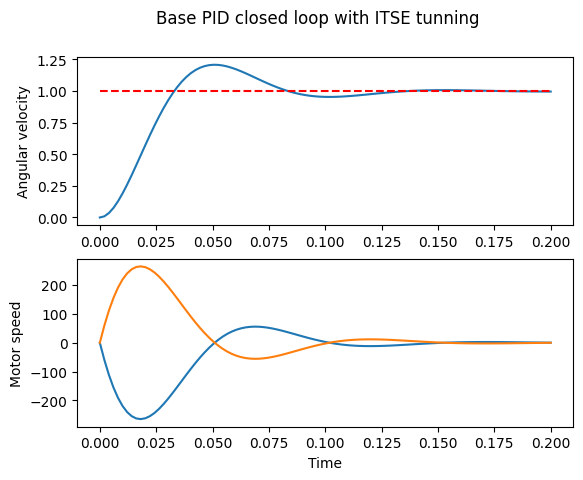

In [13]:
kp, ti, td = itse_best.x
itse_pid = gen_pid(kp, ti, td)
itse_loop = ct.series(itse_pid, quadcopter).feedback(feedback)
itse_step = ct.step_response(itse_loop, T=0.2, output=1)
itse_info = ct.step_info(ct.series(itse_loop, ct.ss([], [], [], [0, 1])), T=0.5, yfinal=1)
score = itse(itse_step.time, itse_step.outputs[0])
fig, axs = plt.subplots(2)
fig.suptitle('Base PID closed loop with ITSE tunning')
axs[0].plot(itse_step.time, itse_step.outputs[0][0])
axs[0].plot(itse_step.time, itse_step.u[0][0], '--r')
axs[0].set_ylabel("Angular velocity")
axs[1].plot(itse_step.time, itse_step.states[-3]/(2*np.pi) * 60)
axs[1].plot(itse_step.time, itse_step.states[-4]/(2*np.pi) * 60)
axs[1].set_xlabel("Time")
axs[1].set_ylabel("Motor speed")
md(f"ITSE result:\n- {kp=:.2f}\n- {ti=:.2f}\n- {td=:.2f}\n- {score=:.2f}")

### Comparison

In [14]:
cell = "#### PID parameters\n"
cell += "|Parameters [min, max]|ITAE|ITSE|\n"
cell += "|---------------------|----|----|\n"

for i, param in enumerate(["Kp", "Ti", "Td"]):
    cell += f"|{param} {boundaries[i]}|{itae_best.x[i]:.2f}|{itse_best.x[i]:.2f}|\n"

cell += "\n"
cell += "#### Fitness function metrics\n"
cell += "|Metrics|ITAE|ITSE|\n"
cell += "|-------|----|----|\n"

for metric in ["RiseTime", "SettlingTime", "Overshoot"]:
    cell += f"|{metric}|{itae_info[metric]:.2f}|{itse_info[metric]:.2f}|\n"

md(cell)

#### PID parameters
|Parameters [min, max]|ITAE|ITSE|
|---------------------|----|----|
|Kp [1000.0, 5000.0]|1799.31|2744.53|
|Ti [0.1, 20.0]|1.10|11.36|
|Td [0.1, 30.0]|25.33|22.05|

#### Fitness function metrics
|Metrics|ITAE|ITSE|
|-------|----|----|
|RiseTime|0.03|0.03|
|SettlingTime|0.11|0.12|
|Overshoot|12.77|20.80|


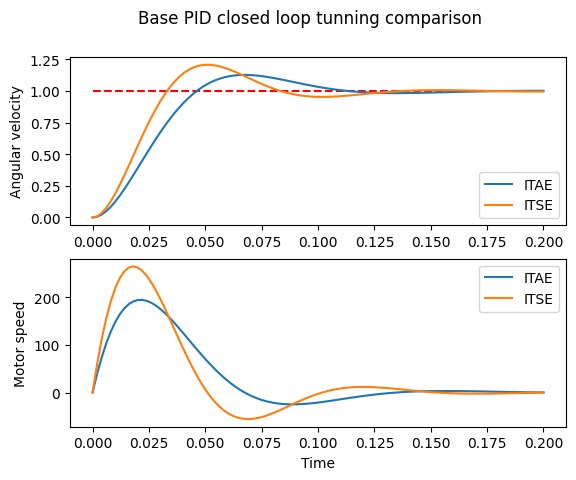

In [15]:
fig, axs = plt.subplots(2)
fig.suptitle('Base PID closed loop tunning comparison')
axs[0].plot(itae_step.time, itae_step.u[0][0], '--r')
axs[0].plot(itae_step.time, itae_step.outputs[0][0], label="ITAE")
axs[0].plot(itse_step.time, itse_step.outputs[0][0], label="ITSE")
axs[0].set_ylabel("Angular velocity")
axs[0].legend()
axs[1].plot(itae_step.time, itae_step.states[-4]/np.pi * 30, label="ITAE")
axs[1].plot(itse_step.time, itse_step.states[-4]/np.pi * 30, label="ITSE")
axs[1].set_xlabel("Time")
axs[1].set_ylabel("Motor speed")
axs[1].legend()

## Advanced PID

/home/tchamelot/workspace/pid-tunning/.venv/lib/python3.12/site-packages/control/nlsys.py:1198: UserWarning: Unused output(s) in InterconnectedSystem: (1, 0) : quadcopter.theta
  warn(msg)


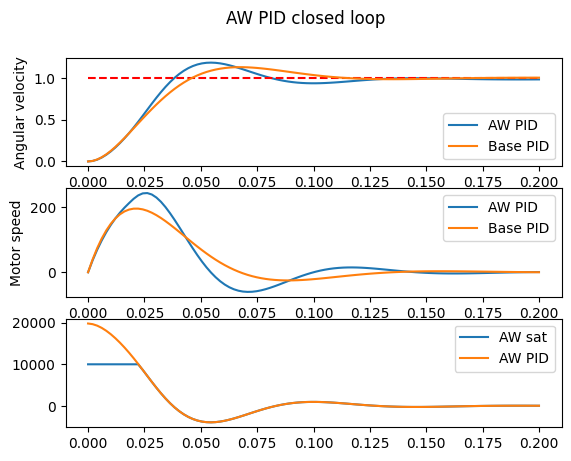

In [16]:
aw_pid = gen_antiwindup_pid(*itae_best.x, umax=10000, kaw=0.001)
aw_loop = ct.interconnect([aw_pid, quadcopter],
                          connections=[
                               ['pid.error', '-quadcopter.theta_dot'],
                               ['pid.measure', '-quadcopter.theta_dot'],
                               ['quadcopter.delta', 'pid.y']],
                          inplist=[['pid.error', 'pid.measure']],
                          inputs=1,
                          outlist=['quadcopter.theta_dot', 'pid.y', 'pid.y_int'])
aw_step = ct.forced_response(aw_loop, T=itae_step.time, U=np.ones(itae_step.time.shape))
fig, axs = plt.subplots(3)
fig.suptitle('AW PID closed loop')
axs[0].plot(aw_step.time, aw_step.outputs[0].T, label="AW PID")
axs[0].plot(aw_step.time, aw_step.u[0], '--r')
axs[0].plot(itae_step.time, itae_step.outputs[0][0], label="Base PID")
axs[0].set_ylabel("Angular velocity")
axs[0].legend()
axs[1].plot(aw_step.time, aw_step.states[-4].T/np.pi * 30, label="AW PID")
axs[1].plot(itae_step.time, itae_step.states[-4]/np.pi * 30, label="Base PID")
axs[1].set_xlabel("Time")
axs[1].set_ylabel("Motor speed")
axs[1].legend()
axs[2].plot(aw_step.time, aw_step.outputs[1].T, label="AW sat")
axs[2].plot(aw_step.time, aw_step.outputs[2].T, label="AW PID")
axs[2].legend()

## Position control

Text(0, 0.5, 'Motor speed')

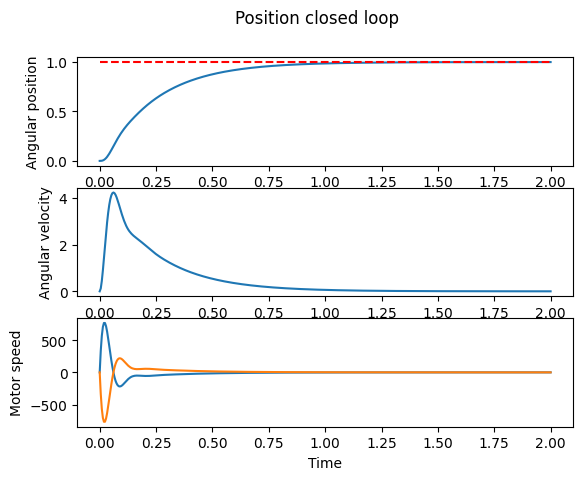

In [17]:
pos_feedback = ct.ss([], [], [], [1, 0])
position_loop = (4 * itae_loop).feedback(pos_feedback)
pos_step = ct.step_response(position_loop, T=2)
fig, axs = plt.subplots(3)
fig.suptitle('Position closed loop')
axs[0].plot(pos_step.time, pos_step.outputs[0][0])
axs[0].plot(pos_step.time, pos_step.u[0][0], '--r')
axs[0].set_ylabel("Angular position")
axs[1].plot(pos_step.time, pos_step.outputs[1][0])
axs[1].set_ylabel("Angular velocity")
axs[2].plot(pos_step.time, pos_step.states[-4].T/np.pi * 30)
axs[2].plot(pos_step.time, pos_step.states[-3].T/np.pi * 30)
axs[2].set_xlabel("Time")
axs[2].set_ylabel("Motor speed")

# Non linear behaviour


Text(0, 0.5, 'Motor speed')

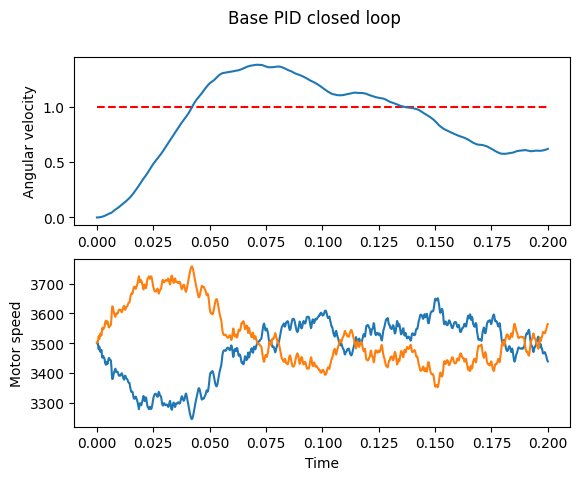

In [18]:

nl_loop = ct.interconnect([itae_pid, thrust, body],
                connections=[
                    ["thrust.delta", "pid.y"],
                    ["body.F_1", "thrust.F_1"],
                    ["body.F_2", "thrust.F_2"],
                    ["pid.u", "-body.theta_dot"],
                ],
                inplist=["pid.u", "thrust.throttle"],
                outlist=["body.theta_dot"],
                ignore_outputs=["body.theta"])
time = np.linspace(0, 0.2, 1000)
noise = np.random.normal(0,2, 1000)
ref = np.ones(time.shape)
throttle = np.ones(time.shape) * hover_throttle
nl_step = ct.input_output_response(nl_loop, T=time, U=[ref + noise, throttle], X0=[0, 0, hover_motor, hover_motor, 0, 0])
fig, axs = plt.subplots(2)
fig.suptitle('Base PID closed loop')
axs[0].plot(time, ref, '--r')
axs[0].plot(time, nl_step.outputs.T)
axs[0].set_ylabel("Angular velocity")
axs[1].plot(nl_step.time, nl_step.states[-3]/np.pi * 30)
axs[1].plot(nl_step.time, nl_step.states[-4]/np.pi * 30)
axs[1].set_xlabel("Time")
axs[1].set_ylabel("Motor speed")

# Discrete PID implementation

In [19]:
zpid = ct.tf(itae_pid.sample(0.01, method="bilinear"))

In [20]:
print(zpid, zpid.num, zpid.den)

<TransferFunction>: pid$sampled$converted
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


1.08e+04 z^2 - 2.157e+04 z + 1.078e+04
--------------------------------------
        z^2 - 1.998 z + 0.998

dt = 0.01
 [[array([ 10795.17617525, -21570.39976001,  10775.25589874])]] [[array([ 1.        , -1.99802828,  0.99802828])]]
